Note: This was originally a take-home research project for a job position with an expected time frame of 3 hours.

Objective: Build a Multinomial Classifier that predicts whether a Movie on Rotten-Tomatoes is labeled as "Rotten", "Fresh", or "Certified Fresh" based on either of two approaches:

1. Using categorical and numerical features (The First Dataset)
2. Using movie review text data (The Second Dataset)

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Specific Imports
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

print("done")

done


Pre-Processing and Exploration

In [2]:
# Read the Data
df_movie = pd.read_csv('rotten_tomatoes_movies.csv')
df_movie.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [3]:
# Explore the distribution
df_movie.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17398.000000,17668.000000,17668.000000,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
mean,102.214048,60.884763,57.139801,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,18.702511,28.443348,68.370047,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.498800e+04,23.000000,44.000000,24.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


Content Rating category: ['PG' 'R' 'NR' 'G' 'PG-13' 'NC17']


[Text(0, 0, '6377'),
 Text(0, 0, '5474'),
 Text(0, 0, '2979'),
 Text(0, 0, '2168'),
 Text(0, 0, '676'),
 Text(0, 0, '38')]

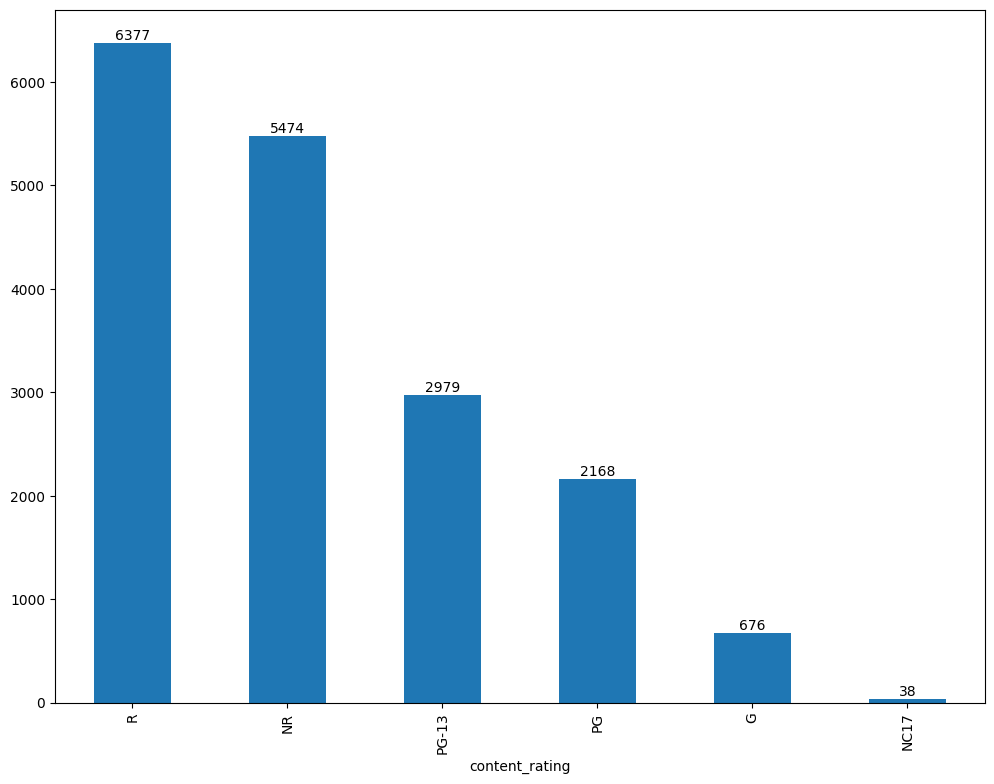

In [4]:
# Visualize the distribution of each category in content_rating feature

print(f'Content Rating category: {df_movie.content_rating.unique()}')
ax = df_movie.content_rating.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

In [5]:
# Dummy Encode the Ratings
content_rating = pd.get_dummies(df_movie.content_rating)
content_rating.head()

,G,NC17,NR,PG,PG-13,R
0,False,False,False,True,False,False
1,False,False,False,False,False,True
2,False,False,False,False,False,True
3,False,False,True,False,False,False
4,True,False,False,False,False,False


Audience status category: ['Spilled' 'Upright' nan]


[Text(0, 0, '9390'), Text(0, 0, '7874')]

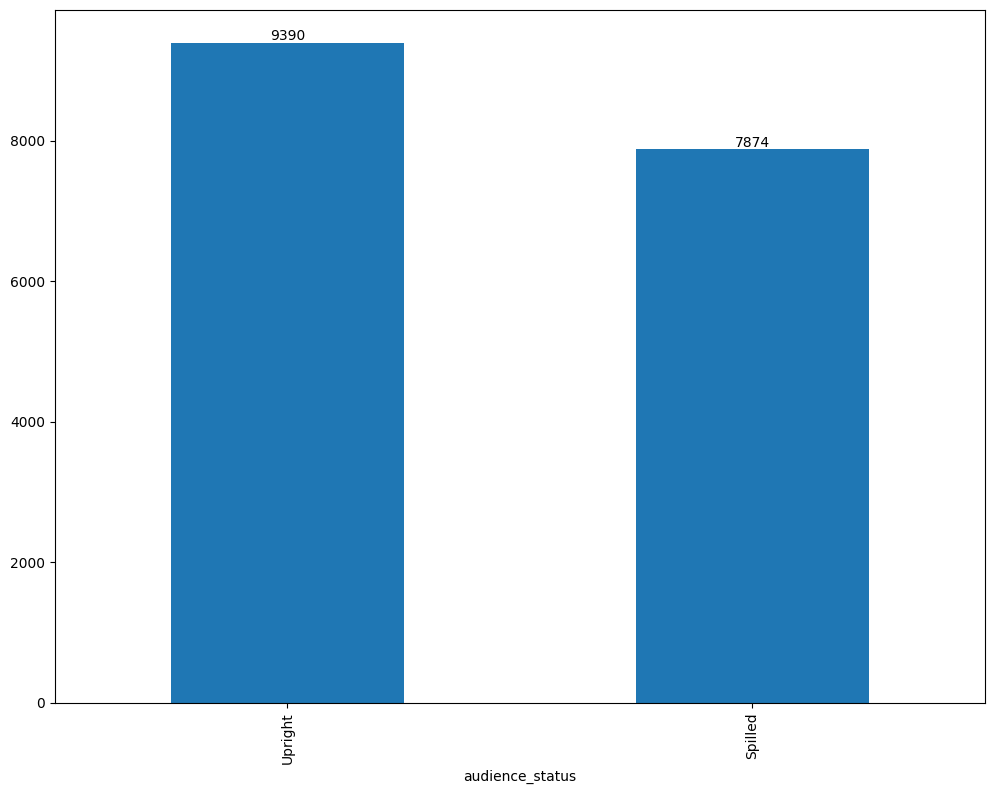

In [6]:
# Repeat with audience status
print(f'Audience status category: {df_movie.audience_status.unique()}')
ax = df_movie.audience_status.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

In [7]:
# Encode Audience Status
audience_status = pd.DataFrame(df_movie.audience_status.replace(['Spilled','Upright'],[0,1]))
audience_status.head()

,audience_status
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0


In [8]:
# Ordinally Encode the Target Variable
tomatometer_status = pd.DataFrame(df_movie.tomatometer_status.replace(['Rotten','Fresh','Certified-Fresh'],[0,1,2]))
tomatometer_status

,tomatometer_status
0,0.0
1,2.0
2,1.0
3,2.0
4,1.0
...,...
17707,0.0
17708,2.0
17709,1.0
17710,1.0


In [9]:
# Combine it all
df_feature = pd.concat([df_movie[['runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']]
                        , content_rating, audience_status, tomatometer_status], axis=1).dropna()
df_feature.head()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,G,NC17,NR,PG,PG-13,R,audience_status,tomatometer_status
0,119.0,49.0,149.0,53.0,254421.0,43,73,76,False,False,False,True,False,False,0.0,0.0
1,90.0,87.0,142.0,64.0,11574.0,44,123,19,False,False,False,False,False,True,1.0,2.0
2,122.0,67.0,24.0,53.0,14684.0,2,16,8,False,False,False,False,False,True,0.0,1.0
3,95.0,100.0,54.0,97.0,105386.0,6,54,0,False,False,True,False,False,False,1.0,2.0
4,127.0,89.0,27.0,74.0,68918.0,5,24,3,True,False,False,False,False,False,1.0,1.0


In [10]:
# Explore Final Dataframe Distribution
df_feature.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,audience_status,tomatometer_status
count,17017.000000,17017.000000,17017.000000,17017.000000,1.701700e+04,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000
mean,102.296233,60.519539,57.097197,60.324499,1.471183e+05,14.765999,36.237292,20.871188,0.542928,0.752718
std,18.653649,28.436397,66.814580,20.480600,1.783955e+06,15.172256,51.362454,29.978900,0.498168,0.747250
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,44.000000,7.410000e+02,3.000000,6.000000,3.000000,0.000000,0.000000
50%,99.000000,66.000000,29.000000,62.000000,4.423000e+03,8.000000,17.000000,8.000000,1.000000,1.000000
75%,111.000000,86.000000,76.000000,77.000000,2.606700e+04,23.000000,44.000000,24.000000,1.000000,1.000000
max,266.000000,100.000000,535.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000,1.000000,2.000000


One of the most important things to ensure is that the target variable isn't heavily imbalanced, which could greatly impair a classifier's performance. If it is we will have to remedy it.

[Text(0, 0, '7375'), Text(0, 0, '6475'), Text(0, 0, '3167')]

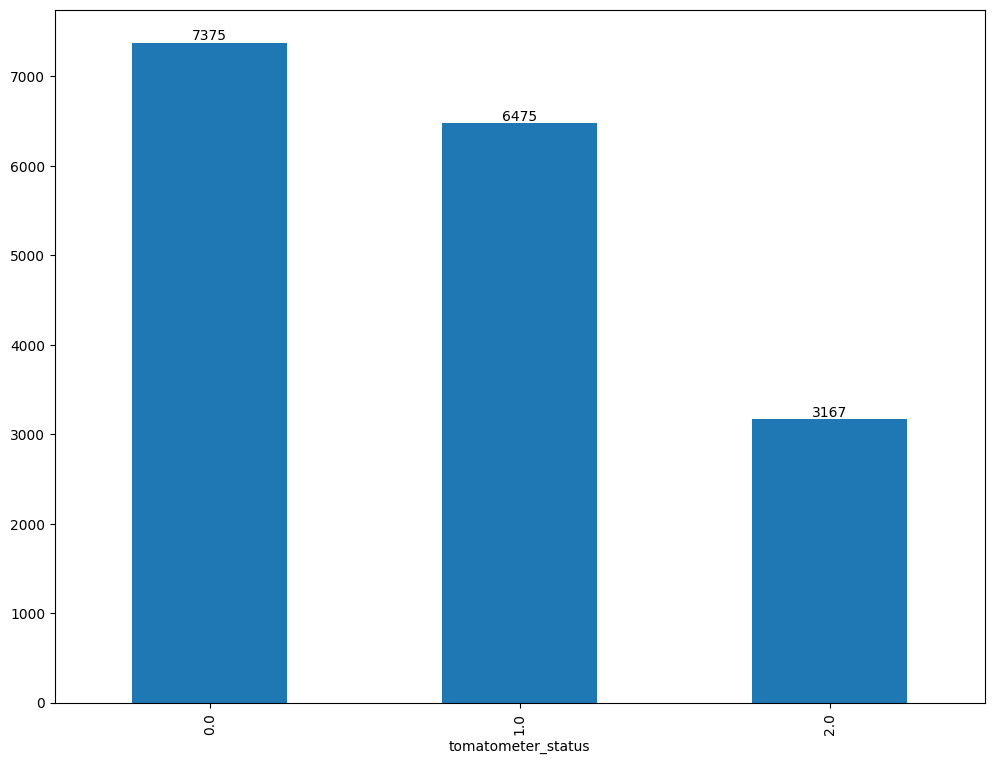

In [11]:
ax = df_feature.tomatometer_status.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

Thankfully, it doesn't appear to be an issue.

In [12]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(df_feature.drop(['tomatometer_status'], axis=1), df_feature.tomatometer_status, test_size= 0.2, random_state=22)
print(f'Size of training data is {len(X_train)} and the size of test data is {len(X_test)}')

Size of training data is 13613 and the size of test data is 3404


Due to time limitations, we will only have time to explore and tune a single form of model. My choice will be a tree-based approach, as they very naturally handle a multinomial classification problem due to their structure, as well as sporting a strong empirical reputation. We begin with a single tree with 3 nodes.

0.9427144535840188
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1497
         1.0       1.00      0.85      0.92      1271
         2.0       0.77      1.00      0.87       636

    accuracy                           0.94      3404
   macro avg       0.92      0.95      0.93      3404
weighted avg       0.96      0.94      0.94      3404



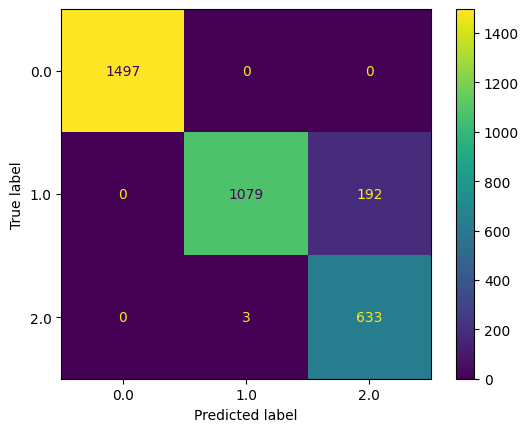

In [13]:
# Fit the model and measure the performance

tree_3_leaf = DecisionTreeClassifier(max_leaf_nodes= 3, random_state=22)
tree_3_leaf.fit(X_train, y_train)
y_predict = tree_3_leaf.predict(X_test)
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))
ConfusionMatrixDisplay.from_estimator(tree_3_leaf, X_test, y_test)

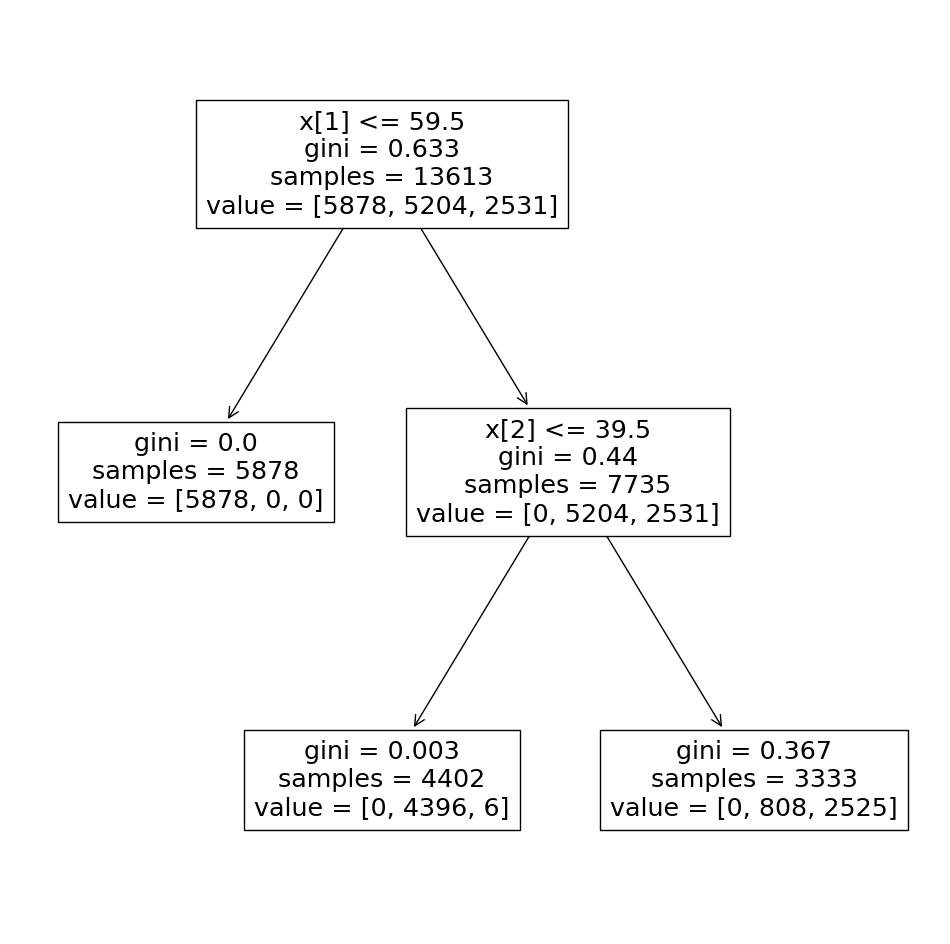

In [14]:
# Visualize the Tree's Decisions

fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(tree_3_leaf, ax= ax)
plt.show()


We now repeat the experiment with an unconstrained tree.

0.9900117508813161
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1497
         1.0       0.99      0.99      0.99      1271
         2.0       0.97      0.97      0.97       636

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



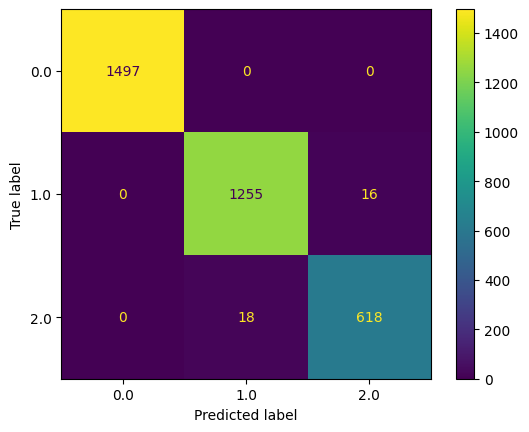

In [15]:
tree = DecisionTreeClassifier(random_state=22)
tree.fit(X_train, y_train)
y_predict = tree.predict(X_test)
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test)

We now try a Random Forest to see if we can improve upon an already strongly performing classifier.

0.9926556991774383
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1497
         1.0       0.99      1.00      0.99      1271
         2.0       0.99      0.97      0.98       636

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



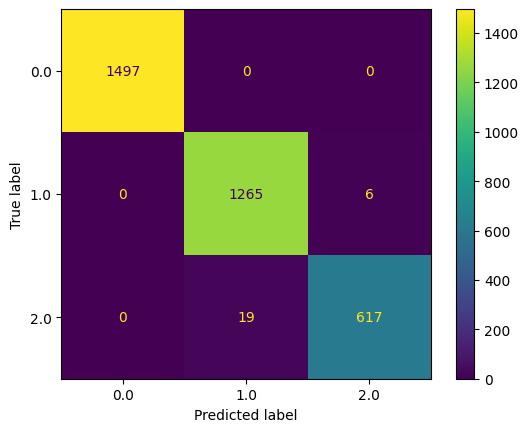

In [16]:
RF = RandomForestClassifier(random_state=22)
RF.fit(X_train, y_train)
y_predict = RF.predict(X_test)
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))
ConfusionMatrixDisplay.from_estimator(RF, X_test, y_test)

The regular Random Forest brings a marginal performance gain. We try some hyperparameter tuning.

0.9926556991774383
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1497
         1.0       0.99      0.99      0.99      1271
         2.0       0.99      0.97      0.98       636

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



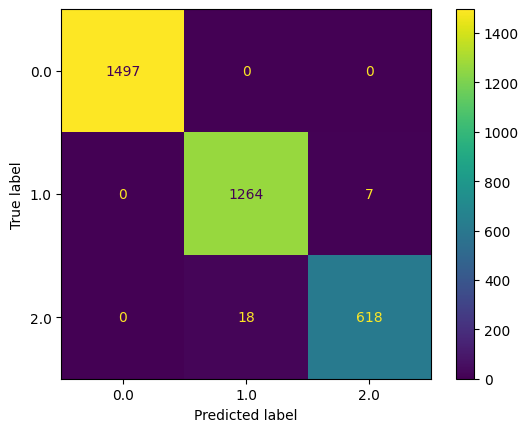

In [17]:
# Hyperparameter Gridsearch

RF_param_grid = {'n_estimators': [200], 'max_features': [2,4,6,8,10,12], 'random_state': [22]}
RandF = GridSearchCV(RandomForestClassifier(), param_grid= RF_param_grid)
RandF.fit(X_train,y_train)
y_predict = RandF.predict(X_test)

print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))
ConfusionMatrixDisplay.from_estimator(RandF, X_test, y_test)

The tuning did not yield any improvement, which is not too surprising as the performance is already extremely strong. We plot the feature importances to get an understanding of which features are driving the response.

runtime = 0.0066413058591183564
tomatometer_rating = 0.4702580397141121
tomatometer_count = 0.09233411994043633
audience_rating = 0.047311917122789156
audience_count = 0.015502533139228445
tomatometer_top_critics_count = 0.04358863339961881
tomatometer_fresh_critics_count = 0.1456075886737299
tomatometer_rotten_critics_count = 0.1333911044485915
G = 0.0003304313830902803
NC17 = 1.8133772759207912e-05
NR = 0.009287585022710801
PG = 0.0004591267759744872
PG-13 = 0.0018449979354584142
R = 0.0011764743658307538
audience_status = 0.0322480084465514


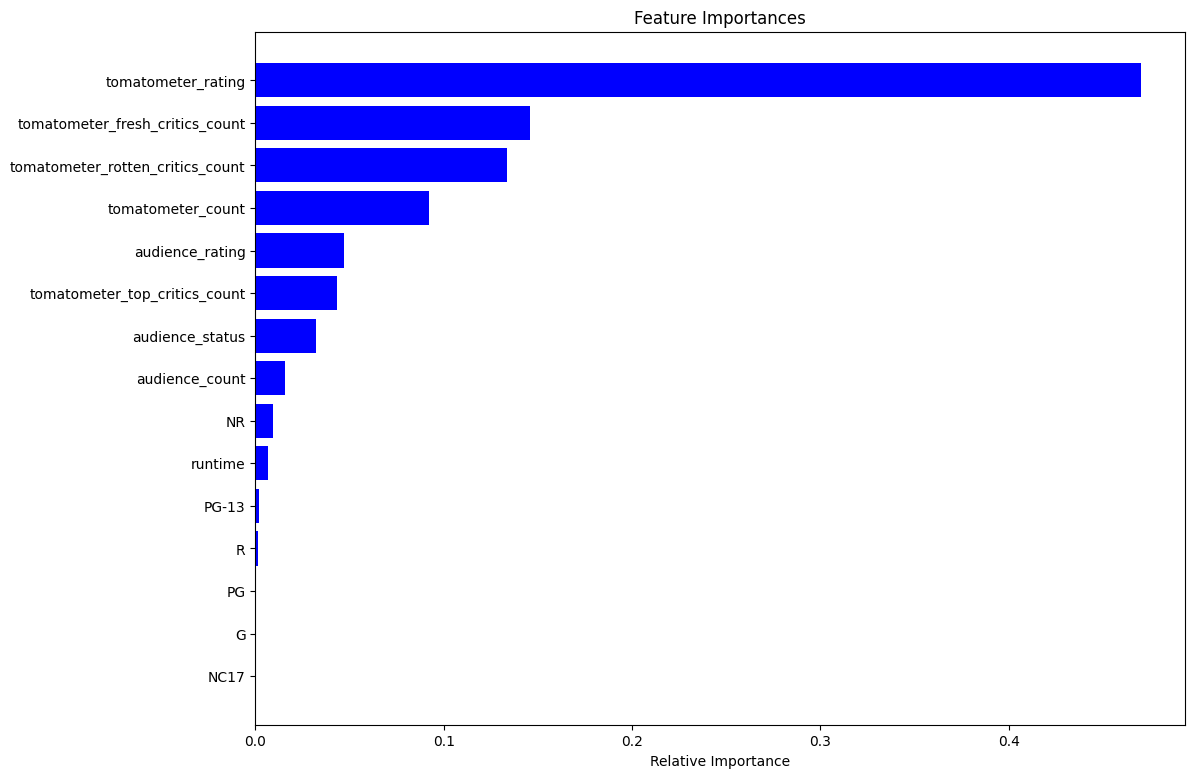

In [18]:
# Visualize the feature importances

feature_importance = RF.feature_importances_


for i, feature in enumerate(X_train.columns):
    print(f'{feature} = {feature_importance[i]}')


indices = np.argsort(feature_importance)

plt.figure(figsize=(12,9))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We now try a second approach, incorporating the second dataset which consists of text data.

In [19]:
# Explore the dataframe
df_critics = pd.read_csv('rotten_tomatoes_critic_reviews_50k.csv')
df_critics.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [20]:
# Merge the dataframes
df_merged = df_critics.merge(df_movie, how='inner', on=['rotten_tomatoes_link'])
df_merged = df_merged[['rotten_tomatoes_link', 'movie_title', 'review_content', 'review_type', 'tomatometer_status']]
df_merged.head()

In [21]:
# Remove the Missing Reviews
df_merged = df_merged.dropna(subset=['review_content'])

[Text(0, 0, '25276'), Text(0, 0, '15919')]

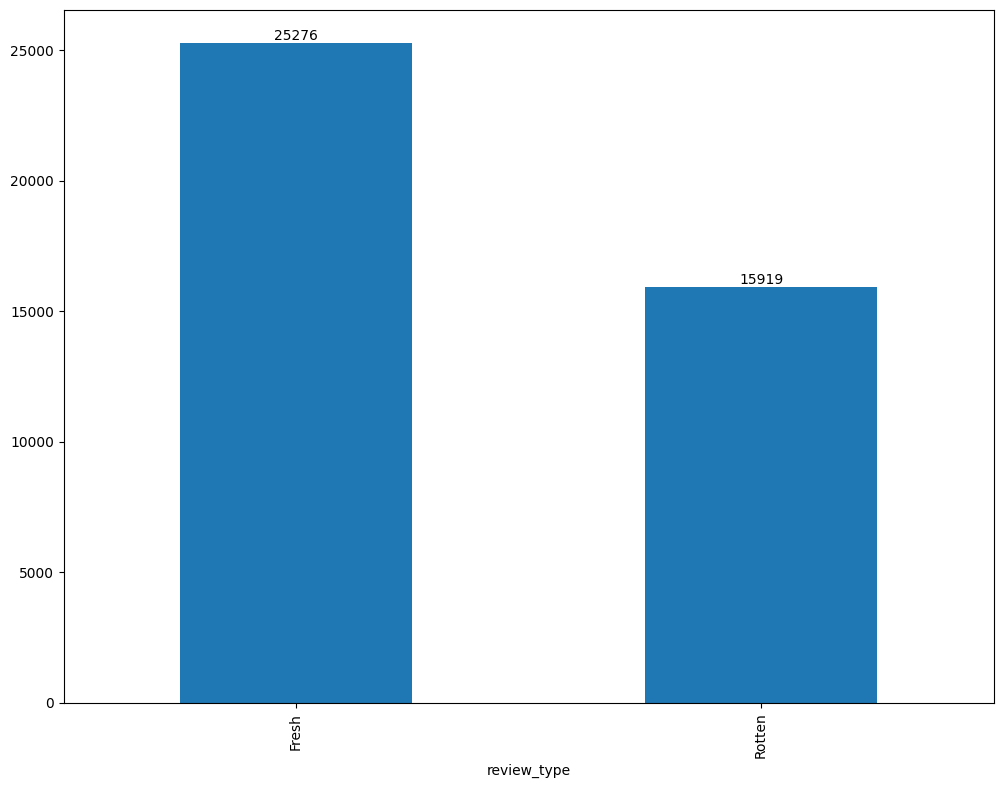

In [22]:
# Plot the distribution
ax = df_merged.review_type.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

In [25]:
# Pick 5000 entries from the original dataset
df_sub = df_merged[0:5000]

# Encode the label
review_type = pd.DataFrame(df_sub.review_type.replace(['Rotten','Fresh'],[0,1]))

# Build final dataframe
df_feature_critics = pd.concat([df_sub[['review_content']],review_type], axis=1).dropna()
df_feature_critics.head()

,review_content,review_type
0,A fantasy adventure that fuses Greek mythology...,1
1,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,With a top-notch cast and dazzling special eff...,1
3,Whether audiences will get behind The Lightnin...,1
4,What's really lacking in The Lightning Thief i...,0


In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split( df_feature_critics['review_content'], df_feature_critics['review_type'], test_size=0.2, random_state=22)

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       458
           1       0.68      0.74      0.71       542

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



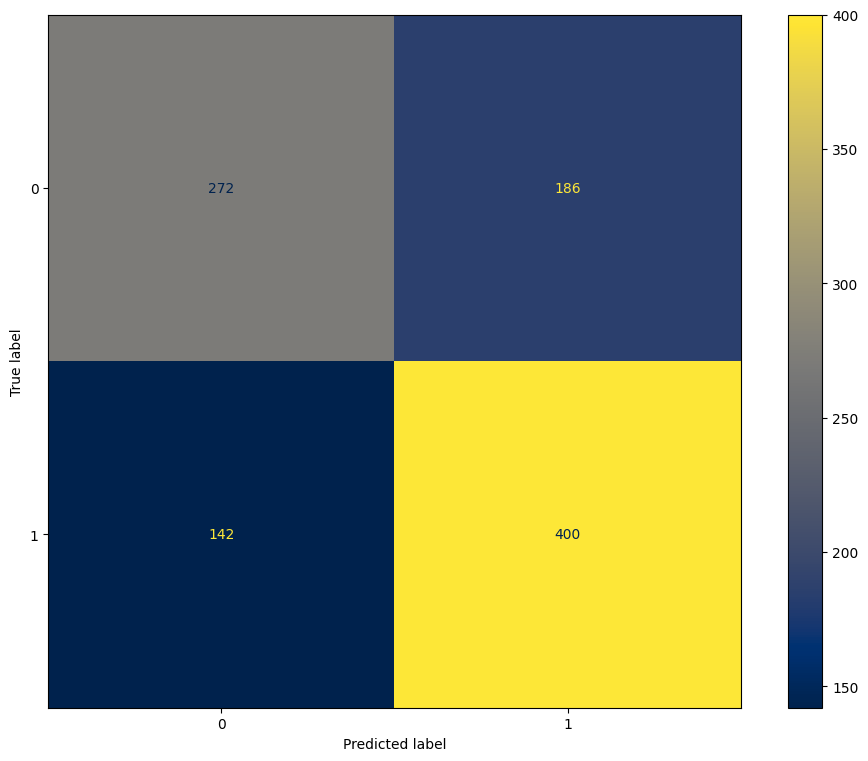

In [27]:
# Vectorize the data and train a default Random Forest
vectorizer = CountVectorizer(min_df=1)

X_train_vec = vectorizer.fit_transform(X_train).toarray()

rf = RandomForestClassifier(random_state=22)
rf.fit(X_train_vec, y_train)

y_predicted = rf.predict(vectorizer.transform(X_test).toarray())

print(classification_report(y_test, y_predicted))

fig, ax = plt.subplots(figsize=(12, 9))
ConfusionMatrixDisplay.from_estimator(rf, vectorizer.transform(X_test).toarray(), y_test, cmap ='cividis', ax=ax)

The performance is poor compared to our previous models. It is doubtful we can match our previous success unless we see a dramatic improvement. We incorporate the class weights to produce a Weighted Random Forest, then assess.

In [28]:
# Calculate class weight
class_weight = compute_class_weight(class_weight= 'balanced', classes= np.unique(df_feature_critics.review_type), y = df_feature_critics.review_type.values)

class_weight_dict = dict(zip(range(len(class_weight.tolist())), class_weight.tolist()))
class_weight_dict

{0: 1.058425063505504, 1: 0.9476876421531463}

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       458
           1       0.72      0.67      0.69       542

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000



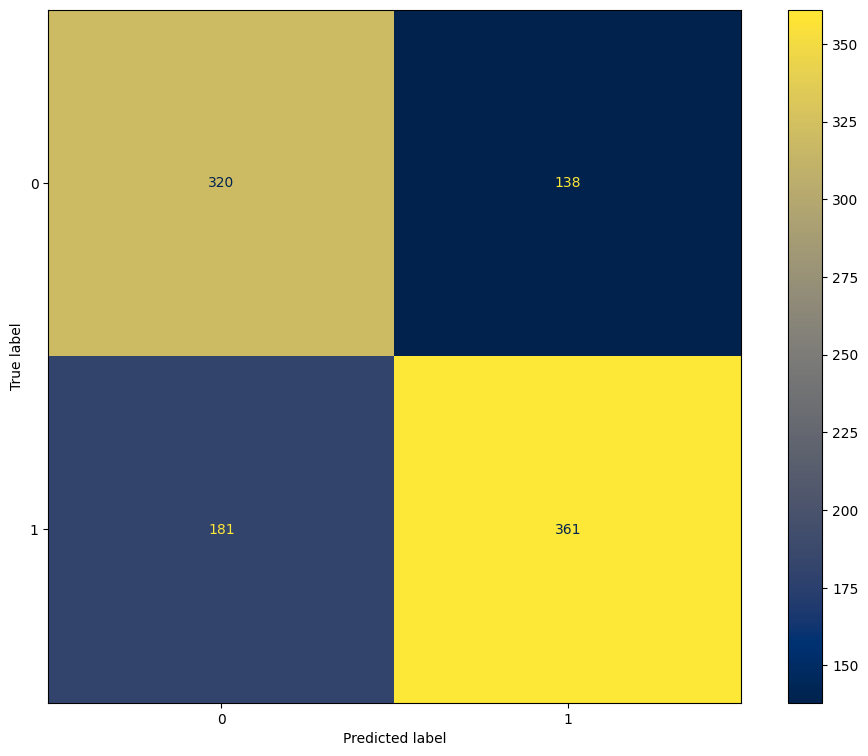

In [30]:
# Weighted Random Forest
vectorizer = CountVectorizer(min_df=1)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
rf_weighted = RandomForestClassifier(random_state=22, class_weight=class_weight_dict)
rf_weighted.fit(X_train_vec, y_train)

y_predicted = rf_weighted.predict(vectorizer.transform(X_test).toarray())

print(classification_report(y_test, y_predicted))

fig, ax = plt.subplots(figsize=(12, 9))
ConfusionMatrixDisplay.from_estimator(rf_weighted, vectorizer.transform(X_test).toarray(), y_test, cmap ='cividis', ax=ax)

We conclude by selecting our original Random Forest as our model of choice for this project, boasting a very strong performance by all measures. This is almost certainly due to the features of the original, tabular dataset being much more informative and related to the response than the text data.